In [34]:
# numpy and scipy
import numpy as np
from scipy.linalg import solve_lyapunov as spl

import scipy.signal as spsg
import scipy.io as sio
import scipy.stats as stats

# MOU model
from test_MOU_largenet import MOUv2

# classification scikit-learn
import sklearn.linear_model as skllm
import sklearn.preprocessing as skppr
import sklearn.pipeline as skppl
import sklearn.neighbors as sklnn

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
import pandas as pd

#statistical tests
import scipy.stats as stats

#importing ENIGMA
from enigmatoolbox.datasets import load_sc_as_one
from nilearn import plotting

#to store results
import os
import pickle

In [35]:
# Data to be analyzed and model parameters
data_dir = './' # data repo
res_dir = './' # results
graph_format = 'png' # graph formatting

conds = ['CTR', 'SCZ'] #conditions
n_cond = len(conds) # number of conditions

N = 68 # number of brain regions

subjects = np.arange(1, 48)
n_sub = len(subjects)

mask_Sigma = np.eye(N, dtype=bool)

In [36]:
# Load control group time series
ts_ctr = sio.loadmat('./ts_ctr.mat')['ts_ctr'] 
ts_ctr = ts_ctr[0:68, :, 20:68]  # Select specific regions and subjects

# Load schizophrenia group time series
ts_scz = sio.loadmat('./ts_scz.mat')['ts_scz']
ts_scz = ts_scz[0:68]  # Select specific regions

# Combine control and schizophrenia time series along a new axis
ts_all = np.stack((ts_ctr, ts_scz), axis=-1)

In [37]:
# Filter design
n_order = 3
TR = 2  # in seconds
Nyquist_freq = 0.5 / TR
low_f = 0.001 / Nyquist_freq
high_f = 0.01 / Nyquist_freq
b, a = spsg.iirfilter(n_order, [low_f, high_f], btype='bandpass', ftype='butter')

In [38]:
# possible functional masks:
def mask_1(FC0p, FC1p, ts_all, i_sub, i_cond):
    ts3 = ts_all[0:68, :, i_sub, i_cond]
    filt_ts = spsg.filtfilt(b, a, ts3, axis=1)
    ts = stats.zscore(filt_ts, axis=1)
    
    FC0 = np.tensordot(ts[:, :-1], ts[:, :-1], axes=(1, 1)) / ts.shape[1]
    mask_EC1 = np.abs(FC0) > np.percentile(np.abs(FC0), FC0p)
    return mask_EC1

def mask_2(FC0p, FC1p, ts_all, i_sub, i_cond):
    ts3 = ts_all[0:68, :, i_sub, i_cond]
    filt_ts = spsg.filtfilt(b, a, ts3, axis=1)
    ts = stats.zscore(filt_ts, axis=1)
    
    FC1 = np.tensordot(ts[:, :-1], ts[:, 1:], axes=(1, 1)) / ts.shape[1]
    mask_EC2 = np.abs(FC1) > np.percentile(np.abs(FC1), FC1p)
    return mask_EC2

def mask_or(FC0p, FC1p, ts_all, i_sub, i_cond):
    return np.logical_or(mask_1(FC0p, FC1p,ts_all, i_sub, i_cond), mask_2(FC0p, FC1p, ts_all, i_sub, i_cond)).astype(int)

def mask_and(FC0p, FC1p, ts_all, i_sub, i_cond):
    return np.logical_and(mask_1(FC0p, FC1p, ts_all, i_sub, i_cond), mask_2(FC0p, FC1p,ts_all, i_sub, i_cond)).astype(int)



In [39]:
def fit_model(ts_all, FC0p, FC1p, mask_function, save_path):
    """
    Fits the model for all subjects, conditions, and parameter sets using a specified mask function.

    Parameters:
        ts_all (array): Time series data.
        FC0p: FC0 percentile thresholds.
        FC1p: FC1 percentile thresholds.
        mask_function (function): The mask function to use for generating the mask.
        save_path (str): Path to save the results.

    Returns:
        dict: Fitting results structured as a dictionary.
    """
    results = {
        "J_mods": np.zeros([n_sub, n_cond, N, N]),
        "Sigma_mods": np.zeros([n_sub, n_cond, N, N]),
        "FC0_mods": np.zeros([n_sub, n_cond, N, N]),
        "err_mods": np.zeros([n_sub, n_cond]),
        "fit_mods": np.zeros([n_sub, n_cond])
    }

    for i_sub in range(n_sub):
        print(f"Processing subject {i_sub + 1}/{n_sub}")
        for i_cond in range(n_cond):

            # Use the selected mask function
            mask_EC = mask_function(FC0p, FC1p, ts_all, i_sub, i_cond)

            # Fit model
            mou_est = MOUv2()
            fit_res = mou_est.fit(
                ts_all[:, :, i_sub, i_cond].T,
                mask_C=mask_EC,
                mask_Sigma=mask_Sigma,
                algo_version='true',
                min_iter=100,
                epsilon_C=0.005,
                epsilon_Sigma=0.005,
            )

            # Store results
            results["J_mods"][i_sub, i_cond, :, :] = fit_res.J
            results["Sigma_mods"][i_sub, i_cond, :, :] = fit_res.Sigma
            results["FC0_mods"][i_sub, i_cond, :, :] = spl(
                results["J_mods"][i_sub, i_cond, :, :].T,
                -results["Sigma_mods"][i_sub, i_cond, :, :]
            )
            results["err_mods"][i_sub, i_cond] = fit_res.d_fit['distance']
            results["fit_mods"][i_sub, i_cond] = fit_res.d_fit['correlation']
    
    # Save results to a file
    with open(save_path, "wb") as f:
        pickle.dump(results, f)
    
    return results


In [40]:
def fit_goodness(results, FC0p, FC1p):
    """
    Visualizes the model error and goodness of fit based on the results from fit_model.

    Parameters:
        results (dict): The dictionary output of fit_model.
        FC0p_list : List of FC0 percentile thresholds.
        FC1p_list : List of FC1 percentile thresholds.

    Returns:
        None
    """
    mask_diag = np.eye(N, dtype=bool)  # mask for diagonal elements
    n_cond = 2

    cols = [[0.3, 0.3, 1], [0.2, 0.2, 0.8], [0.1, 0.1, 0.6], [0, 0, 0.4]]  # colors

    # Extract model error and goodness of fit for the current parameter set
    err_mod = results["err_mods"]
    fit_mod = results["fit_mods"]

    # Prepare data for model error plot
    err_mod_tmp = dict()
    err_mod_tmp["sum EC"] = err_mod.flatten()
    err_mod_tmp["sub"] = np.repeat(np.arange(n_sub), n_cond).flatten()
    err_mod_tmp["cond"] = np.repeat(np.array(conds, dtype=str).reshape([-1, n_cond]), n_sub, axis=0).flatten()

    err_mod_df = pd.DataFrame(err_mod_tmp)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    sb.violinplot(data=err_mod_df, x="cond", y="sum EC", palette=cols)
    sb.swarmplot(data=err_mod_df, x="cond", y="sum EC", color=[0.7, 0.7, 0.7])
    plt.axis(ymin=0)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Condition", fontsize=16)
    plt.ylabel("Model error", fontsize=16)
    plt.title(f"FC0: {FC0p}, FC1: {FC1p}")

    plt.tight_layout()

    # Prepare data for Pearson correlation plot
    fit_mod_tmp = dict()
    fit_mod_tmp["sum EC"] = fit_mod.flatten()
    fit_mod_tmp["sub"] = np.repeat(np.arange(n_sub), n_cond).flatten()
    fit_mod_tmp["cond"] = np.repeat(np.array(conds, dtype=str).reshape([-1, n_cond]), n_sub, axis=0).flatten()

    fit_mod_df = pd.DataFrame(fit_mod_tmp)

    plt.subplot(1, 2, 2)
    sb.violinplot(data=fit_mod_df, x="cond", y="sum EC", palette=cols)
    sb.swarmplot(data=fit_mod_df, x="cond", y="sum EC", color=[0.7, 0.7, 0.7])
    plt.axis(ymin=0)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Condition", fontsize=16)
    plt.ylabel("Model goodness of fit", fontsize=16)
    plt.title(f"FC0: {FC0p}, FC1: {FC1p}")

    plt.tight_layout()
    plt.show()


# Use different masks: 

In [41]:
FC0p = 70
FC1p = 10
fit_model(ts_all, FC0p, FC1p, mask_or, save_path="results_or.pkl")

Processing subject 1/47
Processing subject 2/47
Processing subject 3/47
Processing subject 4/47
Processing subject 5/47
Optimization did not converge. Maximum number of iterations arrived.
Processing subject 6/47
Processing subject 7/47
Processing subject 8/47
Processing subject 9/47
Processing subject 10/47
Processing subject 11/47
Processing subject 12/47
Processing subject 13/47
Processing subject 14/47
Processing subject 15/47
Processing subject 16/47
Processing subject 17/47
Processing subject 18/47
Processing subject 19/47
Optimization did not converge. Maximum number of iterations arrived.
Processing subject 20/47
Processing subject 21/47
Processing subject 22/47
Processing subject 23/47
Processing subject 24/47
Processing subject 25/47
Processing subject 26/47
Processing subject 27/47
Processing subject 28/47


KeyboardInterrupt: 

/tmp/ipykernel_51989/3542353588.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=err_mod_df, x="cond", y="sum EC", palette=cols)
/tmp/ipykernel_51989/3542353588.py:33: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=err_mod_df, x="cond", y="sum EC", palette=cols)
/tmp/ipykernel_51989/3542353588.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=fit_mod_df, x="cond", y="sum EC", palette=cols)
/tmp/ipykernel_51989/3542353588.py:54: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=fit_mod_df, x="cond", y="sum EC", palette=cols)


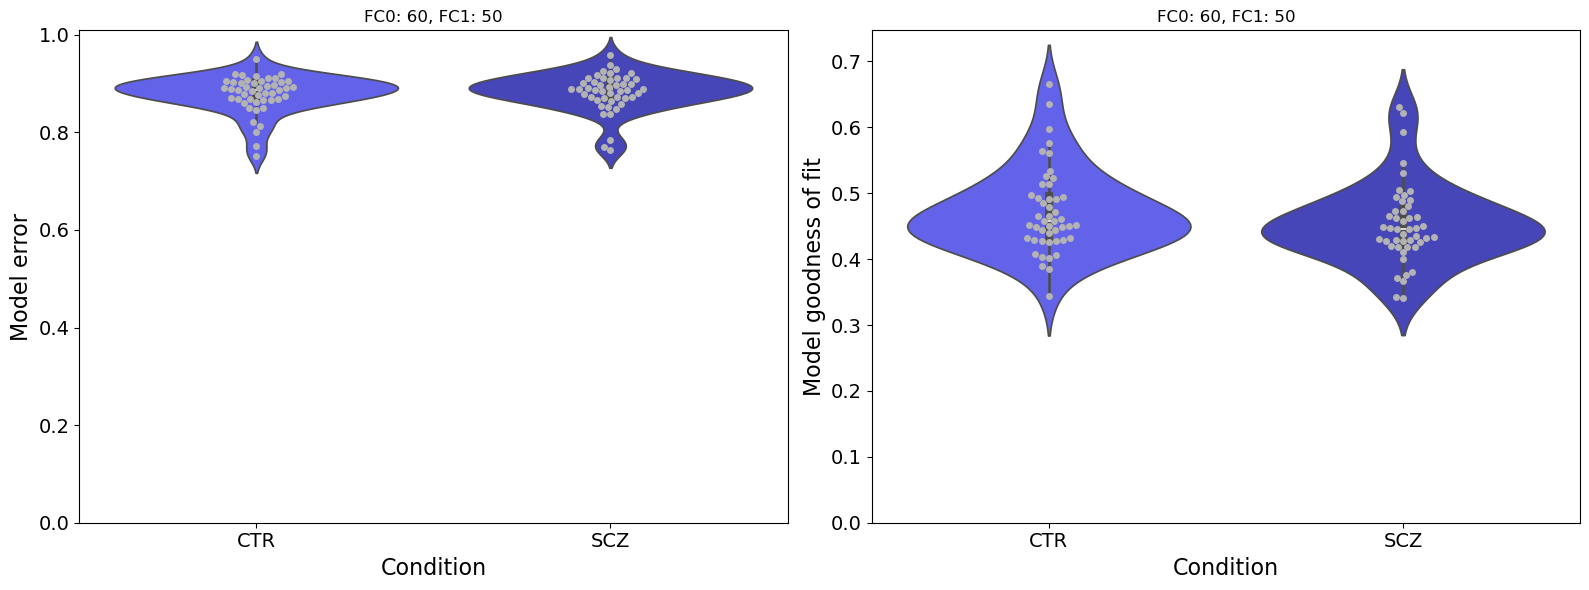

In [33]:

# Define the path where the results are saved
results_path = "results_or.pkl"

# Load the results
with open(results_path, "rb") as f:
    results = pickle.load(f)
    

fit_goodness(results, FC0p, FC1p)

In [ ]:
FC0p_list = [60]
FC1p_list = [50]
fit_model(ts_all, FC0p_list, FC1p_list, mask_and, save_path="results_and.pkl")